In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image

In [ ]:
!unzip /content/drive/MyDrive/sta.zip

In [ ]:
%cd /content/Statistic
gt=pd.read_csv("gt.csv")
from AssignLabel import predict_name
classification=predict_name()

/content/Statistic


In [ ]:
gt.head()

,image,x1,y1,x2,y2,id
0,00000.jpg,774,411,815,446,11
1,00001.jpg,983,388,1024,432,40
2,00001.jpg,386,494,442,552,38
3,00001.jpg,973,335,1031,390,13
4,00002.jpg,892,476,1006,592,39


In [ ]:
net=cv2.dnn.readNet('yolov3.weights','yolov3.cfg')
layer_names=net.getLayerNames()
output_layers=[layer_names[i[0]-1]for i in net.getUnconnectedOutLayers()]

In [ ]:
def detect_objects(image):
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255, size=(416,416),mean=(0,0,0),swapRB= True,crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    return outputs

In [ ]:
def get_boxs(outputs,height,width):
    boxs=[]#list contain information for object(x_left_conner,y_left_conner,width,height)
    confidence_score=[]#confidence score
    class_ids=[]#index class in classes
    for output in outputs:
        for detect in output:
            scores=detect[5:]
            classid=np.argmax(scores)
            conf=scores[classid]
            if conf>0.5:
                x_center=int(detect[0]*width)
                y_center=int(detect[1]*height)
                w=int(detect[2]*width)
                h=int(detect[3]*height)
                x_left_conner=int(x_center-w/2)
                y_left_conner=int(y_center-h/2)
                boxs.append([x_left_conner,y_left_conner,w,h])
                class_ids.append(classid)
                confidence_score.append(float(conf))#need to convert to float,if not,error built-in appear
    return boxs,confidence_score,class_ids

In [ ]:
def load(image):
    image=cv2.imread(str(image))
    height,width=image.shape[:2]
    return image,height,width

In [ ]:
path=os.getcwd()
print(path)
os.chdir('image')
image_names=os.listdir()
bounding_box={}
for name in image_names:
  indexs=np.where(gt['image']==name)[0]
  bounding_box[name]=[]
  for index in indexs:
    bounding_box[name].append(np.array(gt.iloc[index,1:]))

/content/Statistic


In [ ]:
print(bounding_box.get('00001.jpg'))

[array([983, 388, 1024, 432, 40], dtype=object), array([386, 494, 442, 552, 38], dtype=object), array([973, 335, 1031, 390, 13], dtype=object)]


In [ ]:
def get_nearest(box,ground_truth):
    list_dist=[]
    x,y,w,h=box
    t=np.array([x,y,x+w,y+h])
    for i in range(ground_truth.shape[0]):
        dist=np.linalg.norm(np.array(box)/1000-ground_truth[i,:-1]/1000)
        list_dist.append(dist)
    index=np.argmin(np.array(list_dist))
    return ground_truth[index,-1]           
        

In [ ]:
def count_object_correct(boxs,confidences,image,class_id,z,ground_truth):
    confidence_threshold=0.5
    nms_threshold=0.4
    indexs=cv2.dnn.NMSBoxes(boxs,confidences,confidence_threshold,nms_threshold)
    c=0
    ground_truth.shape[0]-len(indexs)
    temp=[]
    for i in indexs:
        temp.append(boxs[i[0]])
    for t in temp:
        x,y,w,h=t
        id=get_nearest(t,ground_truth)
        
        image_crop=image[y-int(y*0.01*z):y+h+int(y*0.01*z),x-int(x*0.01*z):x+w+int(x*0.01*z)]
        name,index=classification.predict(image_crop)
        if index==id:
            c+=1
        
    return (c,ground_truth.shape[0]-len(indexs))

In [ ]:
def count_object_correct1(boxs,confidences,image,class_id,z,ground_truth):
    confidence_threshold=0.5
    nms_threshold=0.4
    indexs=cv2.dnn.NMSBoxes(boxs,confidences,confidence_threshold,nms_threshold)
    c=0
    ground_truth.shape[0]-len(indexs)
    temp=[]
    for i in indexs:
        temp.append(boxs[i[0]])
    for t in temp:
        x,y,w,h=t
        id=get_nearest(t,ground_truth)
        image_crop=image[y-z:y+h+z,x-z:x+w+z]
        name,index=classification.predict(image_crop)
        if index==id:
            c+=1
        
    return (c,ground_truth.shape[0]-len(indexs))

In [ ]:
z=[0,0.5,1,1.5,2,2.5]
sub_images=200
import random
sub_image_names=random.sample(image_names,sub_images)
print(sub_image_names)

['00419.jpg', '00253.jpg', '00433.jpg', '00157.jpg', '00055.jpg', '00104.jpg', '00817.jpg', '00279.jpg', '00567.jpg', '00123.jpg', '00702.jpg', '00766.jpg', '00833.jpg', '00803.jpg', '00278.jpg', '00163.jpg', '00808.jpg', '00005.jpg', '00712.jpg', '00403.jpg', '00824.jpg', '00272.jpg', '00004.jpg', '00304.jpg', '00626.jpg', '00729.jpg', '00871.jpg', '00662.jpg', '00133.jpg', '00358.jpg', '00106.jpg', '00421.jpg', '00630.jpg', '00383.jpg', '00897.jpg', '00542.jpg', '00795.jpg', '00672.jpg', '00690.jpg', '00134.jpg', '00593.jpg', '00485.jpg', '00030.jpg', '00654.jpg', '00257.jpg', '00853.jpg', '00008.jpg', '00066.jpg', '00773.jpg', '00665.jpg', '00051.jpg', '00162.jpg', '00122.jpg', '00418.jpg', '00794.jpg', '00226.jpg', '00742.jpg', '00841.jpg', '00356.jpg', '00188.jpg', '00316.jpg', '00222.jpg', '00075.jpg', '00245.jpg', '00340.jpg', '00317.jpg', '00761.jpg', '00155.jpg', '00480.jpg', '00848.jpg', '00516.jpg', '00277.jpg', '00047.jpg', '00695.jpg', '00774.jpg', '00193.jpg', '00311.jpg'

In [ ]:
result=[]
for i in z:
    count_correct=0
    count_object=0
    count_miss=0
    for name in sub_image_names:
        list_ground_truth=bounding_box.get(name)
        image,height,width=load(name)
        outputs=detect_objects(image)
        boxs,confidences,class_id=get_boxs(outputs,height,width)
        count_object+=len(list_ground_truth)
        (c,miss)=count_object_correct(boxs,confidences,image,class_id,i,np.array(list_ground_truth))
        count_correct+=c
        count_miss+=miss
    b=[count_correct,count_object,count_miss]
    result.append(b)
    print(i)
    

0
0.5
1
1.5
2
2.5


In [ ]:
corrects=[]
totals=[]
miss=[]
for i in result:
    corrects.append(i[0])
    totals.append(i[1])
    miss.append(i[2])
print(totals)
print(corrects)
print(miss)
z1=[str(i)+'%' for i in z]

[333, 333, 333, 333, 333, 333]
[146, 175, 185, 189, 178, 155]
[8, 8, 8, 8, 8, 8]


In [ ]:
df=pd.DataFrame({'Object miss':miss,'Correct':corrects,'Total object':totals},index=z1)
df

,Object miss,Correct,Total object
0%,8,146,333
0.5%,8,175,333
1%,8,185,333
1.5%,8,189,333
2%,8,178,333
2.5%,8,155,333


<Figure size 1440x1440 with 0 Axes>

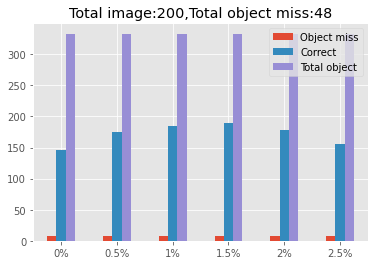

In [ ]:
os.chdir("..")
os.chdir("..")
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
plt.figure(figsize=(20,20))
fig=df.plot.bar(rot=0)
plt.title("Total image:{},Total object miss:{}".format(sub_images,sum(miss)))
plt.savefig('result1.png')

In [ ]:
%cd /content/

/content


In [ ]:
z1=[4,8,9,10,11,12,15]
os.chdir('Statistic/image')
image_names1=os.listdir()
print(image_names1)
sub=200
import random
sub_image_names1=random.sample(image_names1,sub)
print(sub_image_names1)

['00191.jpg', '00310.jpg', '00279.jpg', '00207.jpg', '00477.jpg', '00291.jpg', '00835.jpg', '00058.jpg', '00685.jpg', '00239.jpg', '00515.jpg', '00492.jpg', '00722.jpg', '00633.jpg', '00761.jpg', '00208.jpg', '00136.jpg', '00172.jpg', '00497.jpg', '00025.jpg', '00341.jpg', '00244.jpg', '00700.jpg', '00889.jpg', '00230.jpg', '00178.jpg', '00188.jpg', '00764.jpg', '00513.jpg', '00671.jpg', '00109.jpg', '00603.jpg', '00010.jpg', '00859.jpg', '00147.jpg', '00531.jpg', '00026.jpg', '00257.jpg', '00854.jpg', '00807.jpg', '00102.jpg', '00287.jpg', '00486.jpg', '00138.jpg', '00733.jpg', '00864.jpg', '00440.jpg', '00107.jpg', '00794.jpg', '00323.jpg', '00303.jpg', '00420.jpg', '00259.jpg', '00622.jpg', '00408.jpg', '00065.jpg', '00351.jpg', '00162.jpg', '00656.jpg', '00391.jpg', '00458.jpg', '00182.jpg', '00300.jpg', '00410.jpg', '00836.jpg', '00689.jpg', '00813.jpg', '00660.jpg', '00388.jpg', '00664.jpg', '00669.jpg', '00196.jpg', '00177.jpg', '00642.jpg', '00894.jpg', '00301.jpg', '00286.jpg'

In [ ]:
result1=[]
for i in z1:
    count_correct=0
    count_object=0
    count_miss=0
    for name1 in sub_image_names1:
        list_ground_truth=bounding_box.get(name1)
        image,height,width=load(name1)
        outputs=detect_objects(image)
        boxs,confidences,class_id=get_boxs(outputs,height,width)
        count_object+=len(list_ground_truth)
        (c,miss)=count_object_correct1(boxs,confidences,image,class_id,i,np.array(list_ground_truth))
        count_correct+=c
        count_miss+=miss
    b=[count_correct,count_object,count_miss]
    result1.append(b)
    print(i)
    

4
8
9
10
11
12
15


In [ ]:
print(result1)

[[206, 338, 12], [207, 338, 12], [201, 338, 12], [198, 338, 12], [196, 338, 12], [196, 338, 12], [180, 338, 12]]


In [ ]:
corrects=[]
totals=[]
miss=[]
for i in result1:
    corrects.append(i[0])
    totals.append(i[1])
    miss.append(i[2])
print(totals)
print(corrects)
print(miss)

[338, 338, 338, 338, 338, 338, 338]
[206, 207, 201, 198, 196, 196, 180]
[12, 12, 12, 12, 12, 12, 12]


In [ ]:
df=pd.DataFrame({'Object miss':miss,'Correct':corrects,'Total object':totals},index=z1)
df

,Object miss,Correct,Total object
4,12,206,338
8,12,207,338
9,12,201,338
10,12,198,338
11,12,196,338
12,12,196,338
15,12,180,338


/content


<Figure size 1440x1440 with 0 Axes>

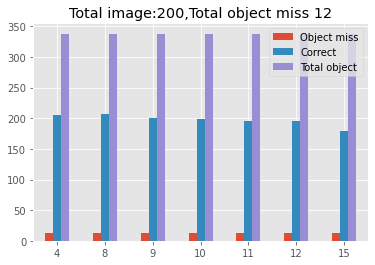

In [ ]:
%cd /content/
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
plt.figure(figsize=(20,20))
fig=df.plot.bar(rot=0)
plt.title("Total image:{},Total object miss {}".format(sub,max(miss)))
plt.savefig('result2.png')

In [ ]:
!ls